### Examine whether employment or low income status has a higher correlation with crime in Toronto neighbourhoods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
toronto2014 = pd.read_csv("wellbeing_toronto_2014.csv")
toronto2014.set_index('Neighbourhood', inplace=True)
toronto2014.head(3)

,NeighbourhoodId,TotalArea,TotalPopulation,LabourForceCategory,InLabourForce,Unemployed,NotInLabourForce,LowIncomeFamilies,LowIncomePopulation,Assaults,SexualAssaults,BreakEnters,Robberies,VehicleThefts,Thefts,Murders,Arsons
Neighbourhood,,,,,,,,,,,,,,,,,
West Humber-Clairville,1,30.09,33312,27365,17610,1750,9755,3790,7590,259,31,131,82,316,38,3,2
Mount Olive-Silverstone-Jamestown,2,4.60,32954,24980,14655,2175,10320,5010,11540,213,16,34,81,42,3,1,1
Thistletown-Beaumond Heights,3,3.40,10360,8135,4825,530,3315,1080,2350,35,3,23,12,13,1,0,0


### Exploration
<hr>

#### Feature Engineering - definition of new features:
 1. Population Density is the a ward's population divided by its area in km2
 2. Property Crime is the total of reported crimes in categories Break & Enters, Robberies, Vehicle Thefts, Thefts, Arsons
 3. Violent Crime is the total of reported crimes in categories Assaults, Sexual Assaults, and Murders
 4. Total Crime is the total of both property crimes and violent crimes

In [3]:
toronto2014['PopulationDensity'] = toronto2014['TotalPopulation'] / toronto2014['TotalArea']
toronto2014['PropertyCrimes'] = toronto2014['BreakEnters'] + toronto2014['Robberies'] + toronto2014['VehicleThefts'] + toronto2014['Thefts'] + toronto2014['Arsons']
toronto2014['ViolentCrimes'] = toronto2014['Assaults'] + toronto2014['SexualAssaults'] + toronto2014['Murders']
toronto2014['TotalCrime'] = toronto2014['PropertyCrimes'] + toronto2014['ViolentCrimes']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x111cb24a8>,
      dtype=object)

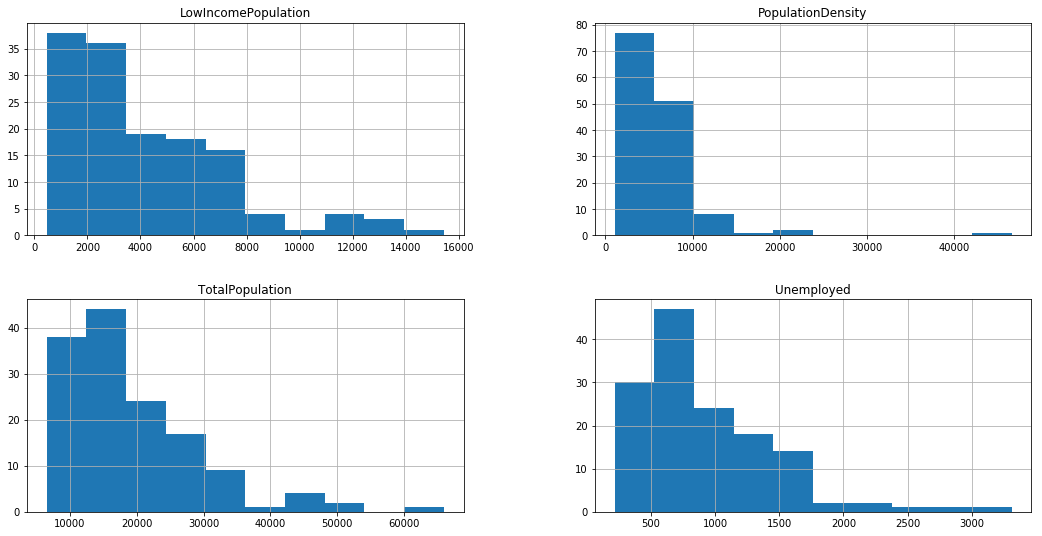

In [116]:
toronto2014.hist(column=['TotalPopulation','PopulationDensity','Unemployed','LowIncomePopulation']
                , figsize=(18,9))

#### Exploratory Visualization

In the pair plots below, the population density does not demonstrate a linear relationship with crime. It is therefore dropped from further analysis.

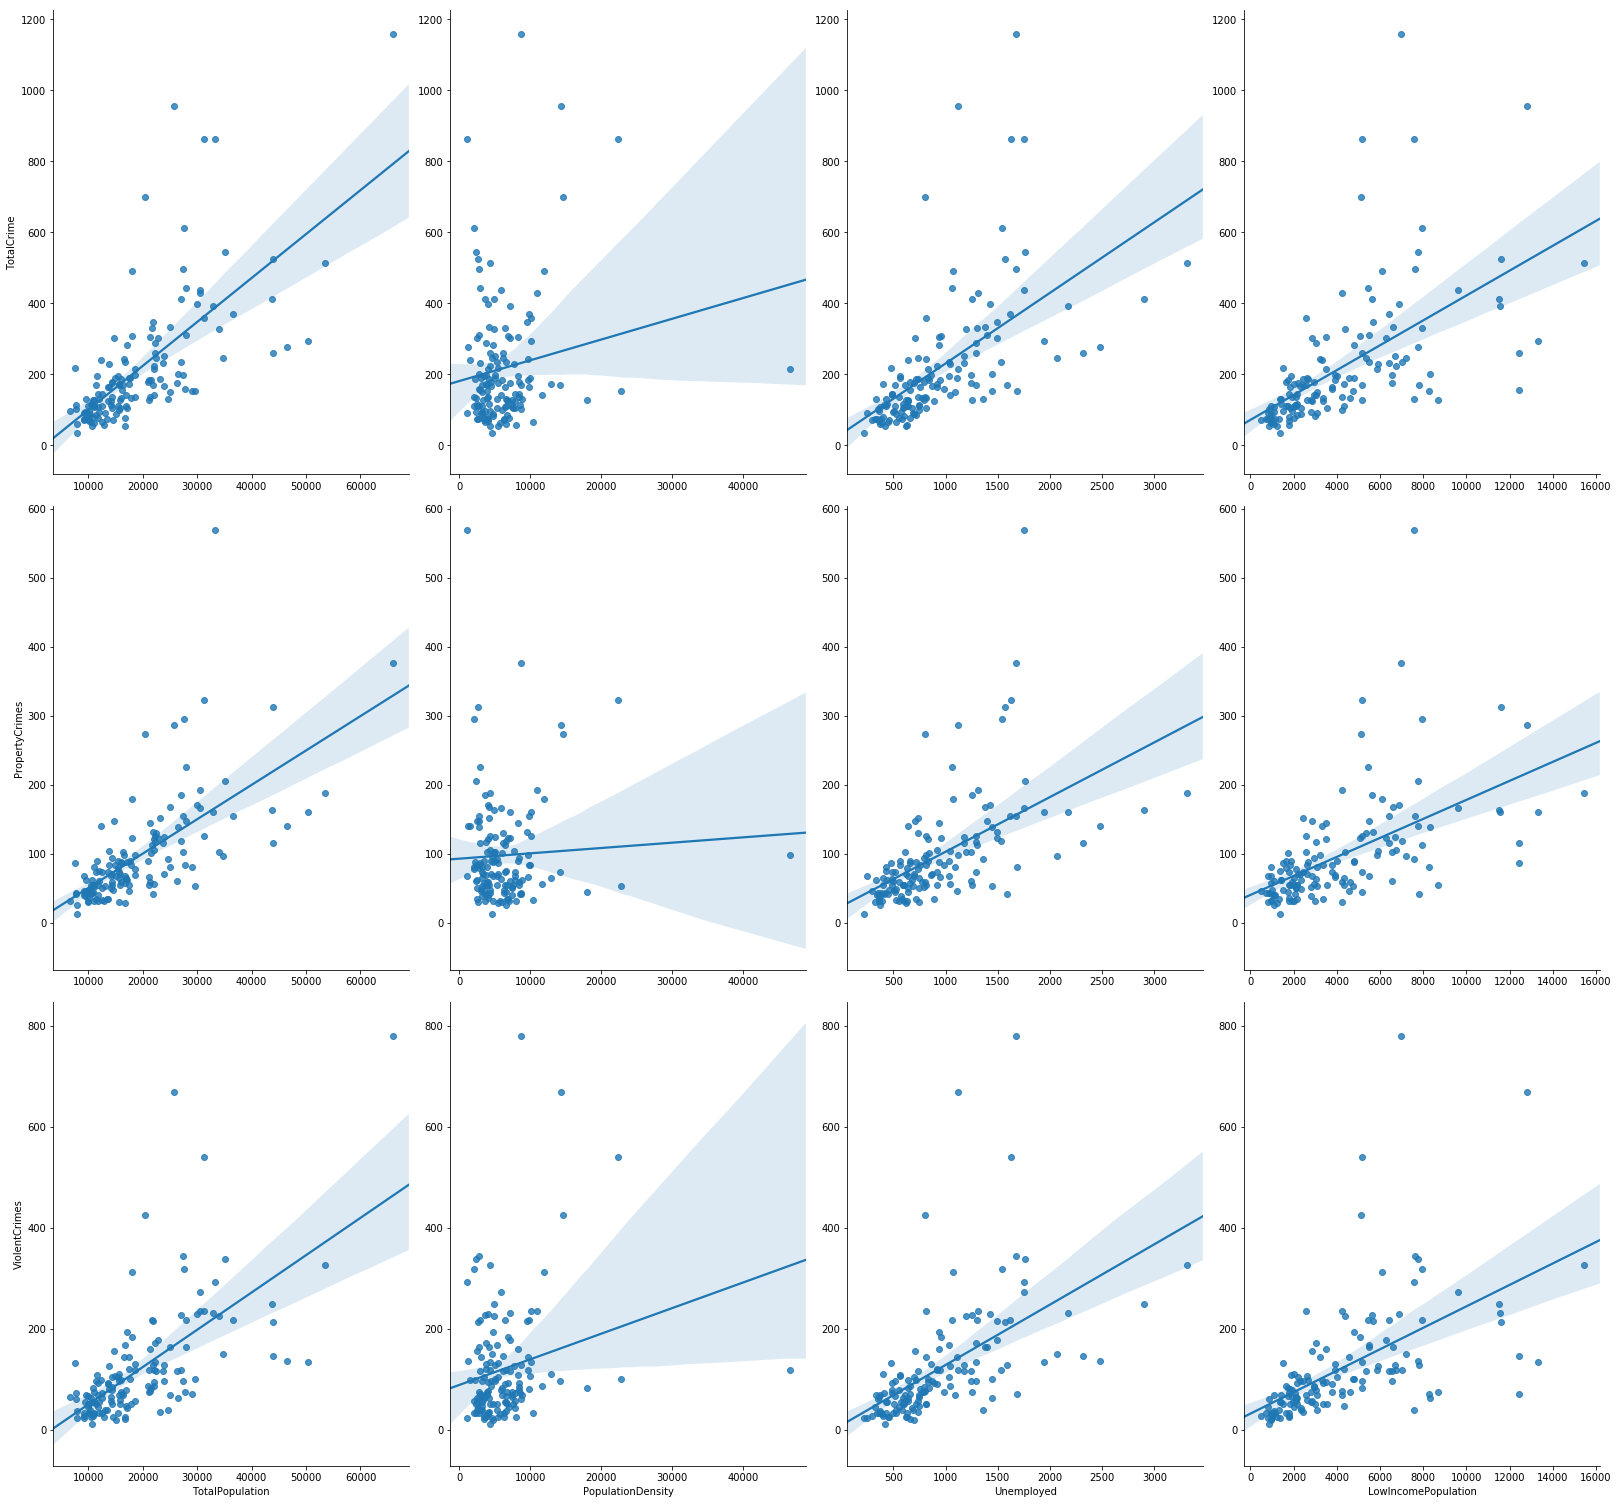

In [117]:
sns.pairplot(toronto2014, x_vars=['TotalPopulation','PopulationDensity','Unemployed','LowIncomePopulation']
            , y_vars=['TotalCrime','PropertyCrimes','ViolentCrimes']
            , size=7, aspect=0.8, kind='reg')
plt.savefig("Crime_Pairplot")

#### Defining the scope of the linear regression models

To evaluate whether focus should be on specific crime(s) or overall crime statistics, linear regression models are fitted for each type and 3 aggregate numbers, using predictors:

1. The number of low income population in the ward
2. The number of population in labour force and working
3. The total population of the ward

In [130]:
Crimes = ['TotalCrime','PropertyCrimes','ViolentCrimes','BreakEnters', 'Robberies','VehicleThefts','Thefts','Arsons','Assaults','SexualAssaults','Murders']

In [141]:
AdjRSquares = pd.DataFrame(index=Crimes
                           , columns=['LowIncomePopulation','InLabourForce','Unemployed','ThreeEconPredictors'
                                      ,'TotalPopulation','PopulationAndEconPredictors'])

In [142]:
for t in Crimes:
    m1 = ols(t + " ~ LowIncomePopulation", data=toronto2014).fit()
    AdjRSquares.loc[AdjRSquares.index == t, 'LowIncomePopulation'] = m1.rsquared_adj
    m2 = ols(t + " ~ InLabourForce", data=toronto2014).fit()
    AdjRSquares.loc[AdjRSquares.index == t, 'InLabourForce'] = m2.rsquared_adj
    m3 = ols(t + " ~ Unemployed", data=toronto2014).fit()
    AdjRSquares.loc[AdjRSquares.index == t, 'Unemployed'] = m3.rsquared_adj
    m4 = ols(t + " ~ LowIncomePopulation + InLabourForce + Unemployed", data=toronto2014).fit()
    AdjRSquares.loc[AdjRSquares.index == t, 'ThreeEconPredictors'] = m4.rsquared_adj
    m5 = ols(t + " ~ TotalPopulation", data=toronto2014).fit()
    AdjRSquares.loc[AdjRSquares.index == t, 'TotalPopulation'] = m5.rsquared_adj
    m6 = ols(t + " ~ LowIncomePopulation + Unemployed + TotalPopulation", data=toronto2014).fit()
    AdjRSquares.loc[AdjRSquares.index == t, 'PopulationAndEconPredictors'] = m6.rsquared_adj

In [143]:
AdjRSquares

,LowIncomePopulation,InLabourForce,Unemployed,ThreeEconPredictors,TotalPopulation,PopulationAndEconPredictors
TotalCrime,0.348345,0.446824,0.342122,0.490078,0.474709,0.490206
PropertyCrimes,0.304271,0.419008,0.307201,0.450627,0.435418,0.444606
ViolentCrimes,0.318338,0.389756,0.307021,0.43169,0.420447,0.435506
BreakEnters,0.185714,0.465896,0.221852,0.509053,0.442033,0.481333
Robberies,0.323687,0.246661,0.315273,0.341607,0.27801,0.340818
VehicleThefts,0.14381,0.129116,0.129896,0.152987,0.150071,0.156806
Thefts,0.20286,0.367733,0.170103,0.453206,0.369411,0.437614
Arsons,0.123183,0.140565,0.124436,0.147756,0.148823,0.145436
Assaults,0.326577,0.3982,0.320758,0.438848,0.432478,0.44573
SexualAssaults,0.202183,0.268895,0.15814,0.329262,0.270346,0.305715


#### Using a multi-variate linear regression model with predictors low income population and employed population produce the highest adjusted R-squared. While property crimes tend to have a stronger correlation with economic indicators than violent crimes, the detailed analysis will focus on the total of both.

### Linear Regression Analysis

In [6]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

                            OLS Regression Results                            
Dep. Variable:             TotalCrime   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     75.30
Date:                Sat, 21 Jul 2018   Prob (F-statistic):           1.01e-14
Time:                        14:21:27   Log-Likelihood:                -894.30
No. Observations:                 140   AIC:                             1793.
Df Residuals:                     138   BIC:                             1798.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              71.7478    

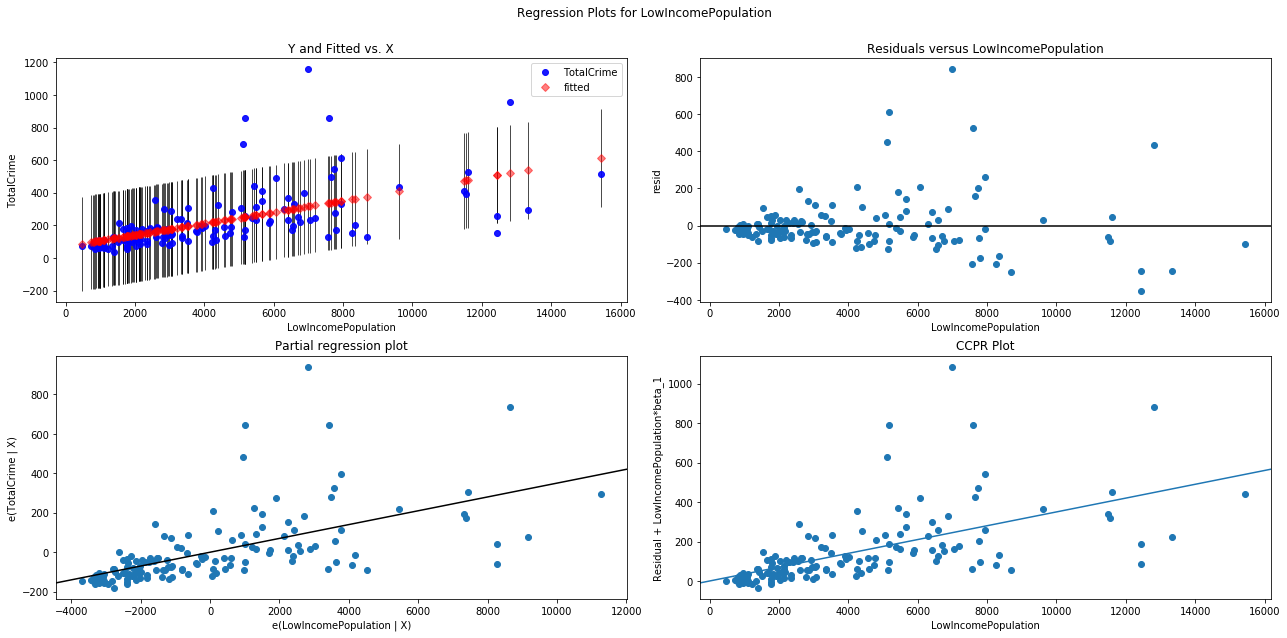

In [7]:
model_allcrime_lowincome = ols("TotalCrime ~ LowIncomePopulation", data=toronto2014).fit()
print(model_allcrime_lowincome.summary())

fig = plt.figure(figsize=(18,9))
fig = sm.graphics.plot_regress_exog(model_allcrime_lowincome, "LowIncomePopulation", fig=fig)

                            OLS Regression Results                            
Dep. Variable:             TotalCrime   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     73.29
Date:                Sat, 21 Jul 2018   Prob (F-statistic):           1.95e-14
Time:                        17:03:35   Log-Likelihood:                -894.96
No. Observations:                 140   AIC:                             1794.
Df Residuals:                     138   BIC:                             1800.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     31.8290     24.947      1.276      0.2

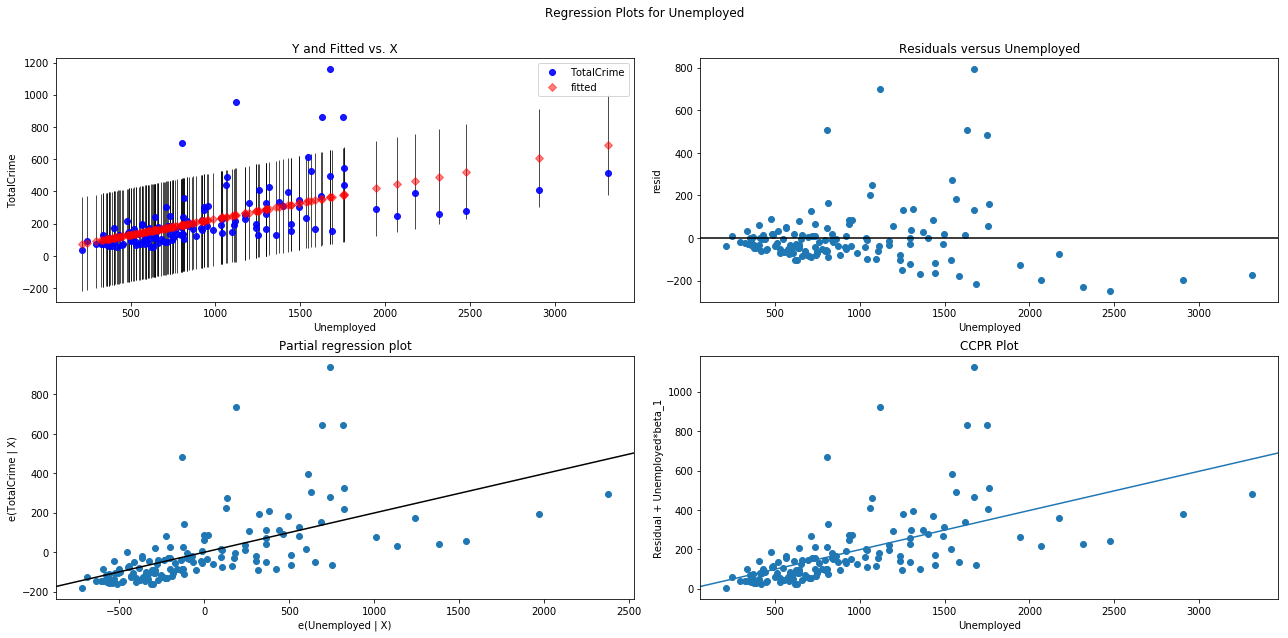

In [121]:
model_allcrime_employment = ols("TotalCrime ~ Unemployed", data=toronto2014).fit()
print(model_allcrime_employment.summary())

fig = plt.figure(figsize=(18,9))
fig = sm.graphics.plot_regress_exog(model_allcrime_employment, "Unemployed", fig=fig)

                            OLS Regression Results                            
Dep. Variable:             TotalCrime   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     41.69
Date:                Sat, 21 Jul 2018   Prob (F-statistic):           7.21e-15
Time:                        17:06:20   Log-Likelihood:                -891.51
No. Observations:                 140   AIC:                             1789.
Df Residuals:                     137   BIC:                             1798.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              39.4917    

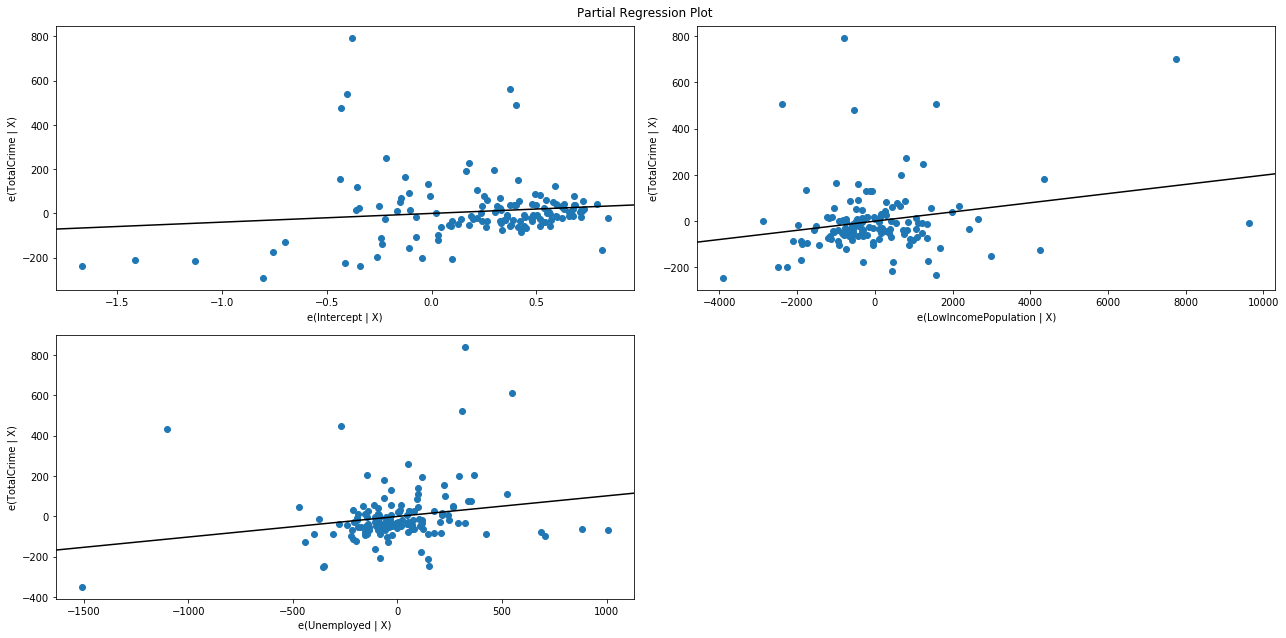

In [125]:
model_allcrime = ols("TotalCrime ~ LowIncomePopulation + Unemployed", data=toronto2014).fit()
print(model_allcrime.summary())

fig = plt.figure(figsize=(18,9))
fig = sm.graphics.plot_partregress_grid(model_allcrime, fig=fig)

#### Effect of outliers

Given the Toronto Island has low population and is 

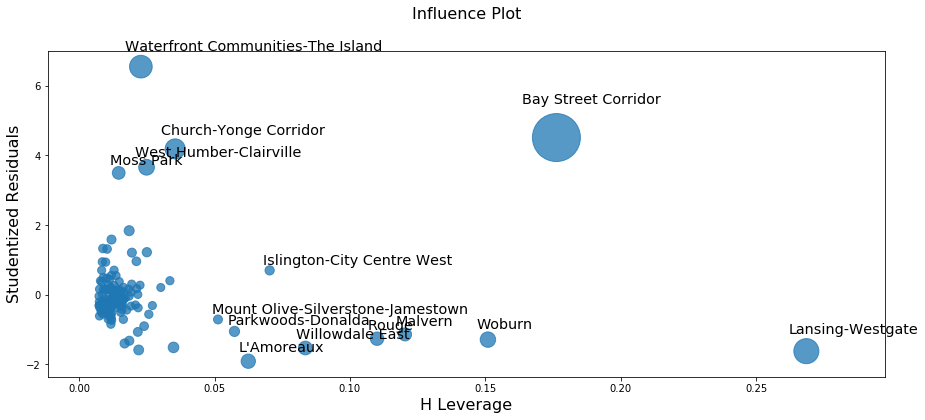

In [126]:
fig, ax = plt.subplots(figsize=(15,6))
plt.title("", y=1.08)
fig = sm.graphics.influence_plot(model_allcrime, ax=ax)

                            OLS Regression Results                            
Dep. Variable:             TotalCrime   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     54.47
Date:                Sat, 21 Jul 2018   Prob (F-statistic):           4.21e-18
Time:                        15:29:27   Log-Likelihood:                -862.41
No. Observations:                 139   AIC:                             1731.
Df Residuals:                     136   BIC:                             1740.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              14.0881    

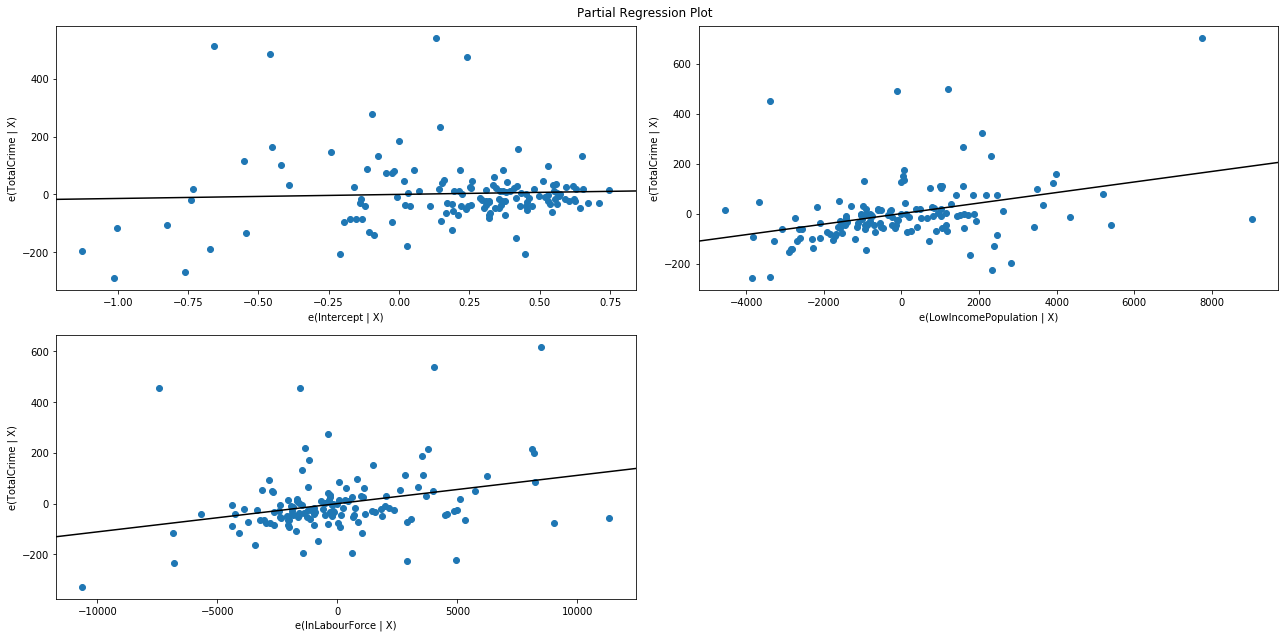

In [33]:
subset = ~toronto2014.index.isin(["Waterfront Communities-The Island"])
model_allcrime2 = ols("TotalCrime ~ LowIncomePopulation + InLabourForce", data=toronto2014, subset=subset).fit()
print(model_allcrime2.summary())

fig = plt.figure(figsize=(18,9))
fig = sm.graphics.plot_partregress_grid(model_allcrime2,fig=fig)

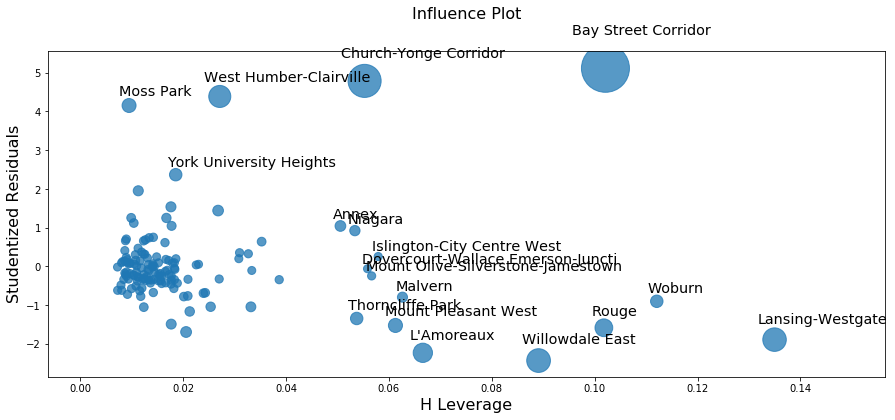

In [26]:
fig, ax = plt.subplots(figsize=(15,6))
plt.title("", y=1.08)
fig = sm.graphics.influence_plot(model_allcrime2, ax=ax)